# Baseline Models - Ambient Sound Classification

**Goal**: Train classical ML models (Logistic Regression + SVM) following Lecture 21 patterns

**Approach**:
1. Extract audio features (MFCCs, spectral, time-domain) using librosa
2. Build sklearn Pipelines: StandardScaler → Classifier
3. Hyperparameter tuning with GridSearchCV
4. Evaluate with weighted F1-score (target ≥ 0.85)

**Reference**: Lecture 21 (Face Recognition), Lecture 22 (Project guidance)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

plt.style.use('bmh')
%matplotlib inline

## 1. Load Data

In [2]:
data_training = np.load('training_data_projectB.npy')
labels_training = np.load('training_labels_projectB.npy')

print(f"Data shape: {data_training.shape}")
print(f"Labels shape: {labels_training.shape}")

labels_names = ['Indoor Quiet', 'Street Traffic', 'Kitchen Activity',
                'Human Chatter', 'Nature Sounds']

SAMPLE_RATE = 48000

Data shape: (240000, 1210)
Labels shape: (1210,)


## 2. Feature Extraction

Extract audio features using librosa:
- **Time-domain**: RMS energy, Zero-crossing rate
- **Spectral**: Spectral centroid, rolloff, bandwidth
- **MFCCs**: 13 coefficients with statistics (mean, std, max, min)

**Total: ~62 features per audio sample**

In [3]:
def extract_audio_features(audio, sr=48000):
    features = []
    
    rms = librosa.feature.rms(y=audio)[0]
    features.append(np.mean(rms))
    features.append(np.std(rms))
    
    zcr = librosa.feature.zero_crossing_rate(audio)[0]
    features.append(np.mean(zcr))
    features.append(np.std(zcr))
    
    centroid = librosa.feature.spectral_centroid(y=audio, sr=sr)[0]
    features.append(np.mean(centroid))
    features.append(np.std(centroid))
    
    rolloff = librosa.feature.spectral_rolloff(y=audio, sr=sr)[0]
    features.append(np.mean(rolloff))
    features.append(np.std(rolloff))
    
    bandwidth = librosa.feature.spectral_bandwidth(y=audio, sr=sr)[0]
    features.append(np.mean(bandwidth))
    features.append(np.std(bandwidth))
    
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
    for coef in mfccs:
        features.append(np.mean(coef))
        features.append(np.std(coef))
        features.append(np.max(coef))
        features.append(np.min(coef))
    
    return np.array(features)

print("Testing feature extraction on one sample...")
test_audio = data_training[:, 0]
test_features = extract_audio_features(test_audio, SAMPLE_RATE)
print(f"Feature vector shape: {test_features.shape}")
print(f"Number of features: {len(test_features)}")

Testing feature extraction on one sample...


c:\Users\devin\anaconda3\Lib\site-packages\paramiko\pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
c:\Users\devin\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.Blowfish and will be removed from this module in 45.0.0.
  "class": algorithms.Blowfish,
c:\Users\devin\anaconda3\Lib\site-packages\paramiko\transport.py:243: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,


Feature vector shape: (62,)
Number of features: 62


## 3. Build Feature Matrix

Extract features from all 1210 audio samples

In [4]:
N_SAMPLES = data_training.shape[1]
X = []

print(f"Extracting features from {N_SAMPLES} audio samples...")
for i in range(N_SAMPLES):
    if i % 100 == 0:
        print(f"  Processing sample {i}/{N_SAMPLES}...")
    
    audio = data_training[:, i]
    features = extract_audio_features(audio, SAMPLE_RATE)
    X.append(features)

X = np.array(X)
t = labels_training.astype(int) - 1

print(f"\nFeature extraction complete!")
print(f"Feature matrix X shape: {X.shape}")
print(f"Labels t shape: {t.shape}")
print(f"Labels range: {t.min()} to {t.max()} (0-indexed)")

Extracting features from 1210 audio samples...
  Processing sample 0/1210...
  Processing sample 100/1210...
  Processing sample 200/1210...
  Processing sample 300/1210...
  Processing sample 400/1210...
  Processing sample 500/1210...
  Processing sample 600/1210...
  Processing sample 700/1210...
  Processing sample 800/1210...
  Processing sample 900/1210...
  Processing sample 1000/1210...
  Processing sample 1100/1210...
  Processing sample 1200/1210...

Feature extraction complete!
Feature matrix X shape: (1210, 62)
Labels t shape: (1210,)
Labels range: 0 to 4 (0-indexed)


## 4. Train-Test Split

Following Lecture 21 pattern: stratified split with 80% train / 20% test

In [5]:
X_train, X_test, t_train, t_test = train_test_split(
    X, t,
    test_size=0.2,
    stratify=t,
    random_state=42
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"\nClass distribution in training set:")
unique, counts = np.unique(t_train, return_counts=True)
for label, count in zip(unique, counts):
    print(f"  Class {label} ({labels_names[label]}): {count} samples")

Training set: 968 samples
Test set: 242 samples

Class distribution in training set:
  Class 0 (Indoor Quiet): 196 samples
  Class 1 (Street Traffic): 196 samples
  Class 2 (Kitchen Activity): 200 samples
  Class 3 (Human Chatter): 195 samples
  Class 4 (Nature Sounds): 181 samples


## 5. Baseline Model 1: Logistic Regression

Following Lecture 21 and HW3 Part 2 patterns

In [6]:
lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', SGDClassifier(
        loss='log_loss',
        penalty='l2',
        max_iter=1000,
        tol=1e-3,
        random_state=42,
        n_jobs=-1,
        eta0=0.01
    ))
])

param_grid_lr = {
    'classifier__learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
    'classifier__alpha': [1e-5, 1e-4, 1e-3, 1e-2]
}

print("Training Logistic Regression with GridSearchCV...")
grid_lr = GridSearchCV(
    estimator=lr_pipeline,
    param_grid=param_grid_lr,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=2
)

grid_lr.fit(X_train, t_train)

print(f"\nBest Parameters: {grid_lr.best_params_}")
print(f"Best CV F1-score: {grid_lr.best_score_:.4f}")

Training Logistic Regression with GridSearchCV...
Fitting 5 folds for each of 16 candidates, totalling 80 fits

Best Parameters: {'classifier__alpha': 0.001, 'classifier__learning_rate': 'adaptive'}
Best CV F1-score: 0.8033


## 6. Evaluate Logistic Regression

Following Lecture 21 evaluation pattern

In [7]:
best_lr_model = grid_lr.best_estimator_

y_train_lr = best_lr_model.predict(X_train)
y_test_lr = best_lr_model.predict(X_test)

train_acc_lr = accuracy_score(t_train, y_train_lr)
test_acc_lr = accuracy_score(t_test, y_test_lr)

train_f1_lr = f1_score(t_train, y_train_lr, average='weighted')
test_f1_lr = f1_score(t_test, y_test_lr, average='weighted')

print('='*60)
print('LOGISTIC REGRESSION RESULTS')
print('='*60)
print(f'Accuracy in Training: {train_acc_lr*100:.2f}%')
print(f'Accuracy in Test: {test_acc_lr*100:.2f}%')
print(f'\nWeighted F1 in Training: {train_f1_lr:.4f}')
print(f'Weighted F1 in Test: {test_f1_lr:.4f}')
print('='*60)

LOGISTIC REGRESSION RESULTS
Accuracy in Training: 86.16%
Accuracy in Test: 80.99%

Weighted F1 in Training: 0.8577
Weighted F1 in Test: 0.8078


In [8]:
print('\nClassification Report - Training Set:')
print(classification_report(t_train, y_train_lr, target_names=labels_names, digits=4))

print('\nClassification Report - Test Set:')
print(classification_report(t_test, y_test_lr, target_names=labels_names, digits=4))


Classification Report - Training Set:
                  precision    recall  f1-score   support

    Indoor Quiet     0.8606    0.9133    0.8861       196
  Street Traffic     0.9010    0.9286    0.9146       196
Kitchen Activity     0.8148    0.8800    0.8462       200
   Human Chatter     0.9020    0.9436    0.9223       195
   Nature Sounds     0.8188    0.6243    0.7085       181

        accuracy                         0.8616       968
       macro avg     0.8594    0.8579    0.8555       968
    weighted avg     0.8598    0.8616    0.8577       968


Classification Report - Test Set:
                  precision    recall  f1-score   support

    Indoor Quiet     0.7708    0.7551    0.7629        49
  Street Traffic     0.9333    0.8571    0.8936        49
Kitchen Activity     0.7455    0.8200    0.7810        50
   Human Chatter     0.8246    0.9592    0.8868        49
   Nature Sounds     0.7838    0.6444    0.7073        45

        accuracy                         0.8099    

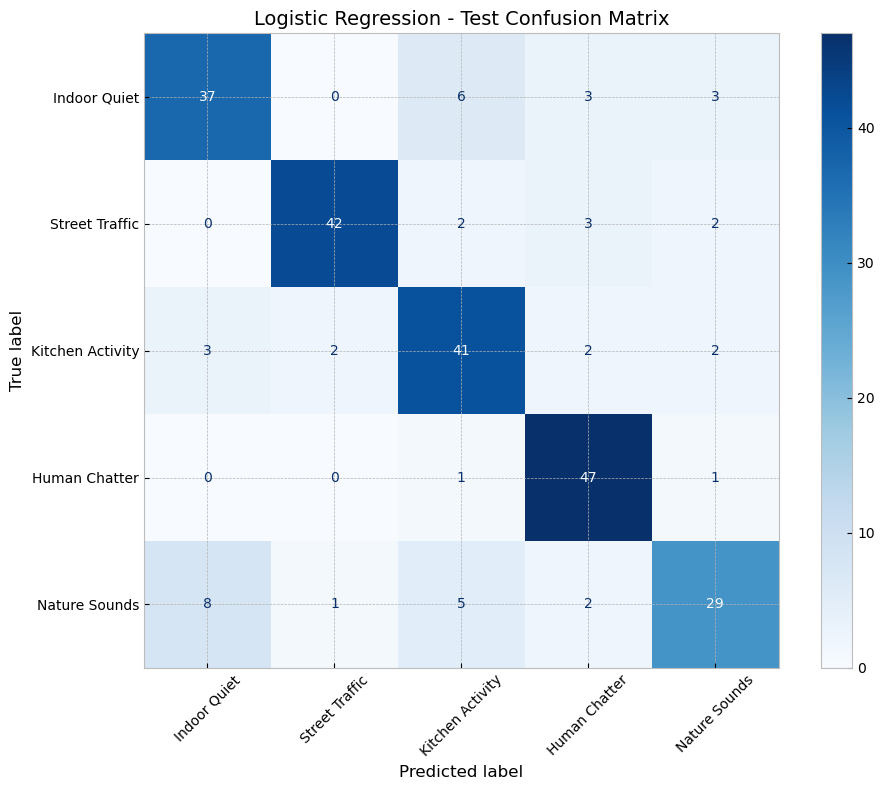

In [9]:
cm_test_lr = confusion_matrix(t_test, y_test_lr)

disp = ConfusionMatrixDisplay(cm_test_lr, display_labels=labels_names)
fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title('Logistic Regression - Test Confusion Matrix', fontsize=14)
plt.tight_layout()
plt.show()

## 7. Baseline Model 2: Support Vector Machine (SVM)

Following Lecture 21 pattern with RBF kernel

In [10]:
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', SVC(
        kernel='rbf',
        random_state=42,
        probability=True
    ))
])

param_grid_svm = {
    'classifier__C': [1, 5, 10, 50],
    'classifier__gamma': [0.0001, 0.0005, 0.001, 0.005]
}

print("Training SVM with GridSearchCV...")
grid_svm = GridSearchCV(
    estimator=svm_pipeline,
    param_grid=param_grid_svm,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=2
)

grid_svm.fit(X_train, t_train)

print(f"\nBest Parameters: {grid_svm.best_params_}")
print(f"Best CV F1-score: {grid_svm.best_score_:.4f}")

Training SVM with GridSearchCV...
Fitting 5 folds for each of 16 candidates, totalling 80 fits

Best Parameters: {'classifier__C': 10, 'classifier__gamma': 0.005}
Best CV F1-score: 0.8814


## 8. Evaluate SVM

In [11]:
best_svm_model = grid_svm.best_estimator_

y_train_svm = best_svm_model.predict(X_train)
y_test_svm = best_svm_model.predict(X_test)

train_acc_svm = accuracy_score(t_train, y_train_svm)
test_acc_svm = accuracy_score(t_test, y_test_svm)

train_f1_svm = f1_score(t_train, y_train_svm, average='weighted')
test_f1_svm = f1_score(t_test, y_test_svm, average='weighted')

print('='*60)
print('SVM (RBF KERNEL) RESULTS')
print('='*60)
print(f'Accuracy in Training: {train_acc_svm*100:.2f}%')
print(f'Accuracy in Test: {test_acc_svm*100:.2f}%')
print(f'\nWeighted F1 in Training: {train_f1_svm:.4f}')
print(f'Weighted F1 in Test: {test_f1_svm:.4f}')
print('='*60)

SVM (RBF KERNEL) RESULTS
Accuracy in Training: 97.73%
Accuracy in Test: 90.08%

Weighted F1 in Training: 0.9772
Weighted F1 in Test: 0.9006


In [12]:
print('\nClassification Report - Training Set:')
print(classification_report(t_train, y_train_svm, target_names=labels_names, digits=4))

print('\nClassification Report - Test Set:')
print(classification_report(t_test, y_test_svm, target_names=labels_names, digits=4))


Classification Report - Training Set:
                  precision    recall  f1-score   support

    Indoor Quiet     0.9652    0.9898    0.9773       196
  Street Traffic     0.9747    0.9847    0.9797       196
Kitchen Activity     0.9703    0.9800    0.9751       200
   Human Chatter     0.9949    0.9949    0.9949       195
   Nature Sounds     0.9826    0.9337    0.9575       181

        accuracy                         0.9773       968
       macro avg     0.9775    0.9766    0.9769       968
    weighted avg     0.9774    0.9773    0.9772       968


Classification Report - Test Set:
                  precision    recall  f1-score   support

    Indoor Quiet     0.9184    0.9184    0.9184        49
  Street Traffic     0.9184    0.9184    0.9184        49
Kitchen Activity     0.8980    0.8800    0.8889        50
   Human Chatter     0.8846    0.9388    0.9109        49
   Nature Sounds     0.8837    0.8444    0.8636        45

        accuracy                         0.9008    

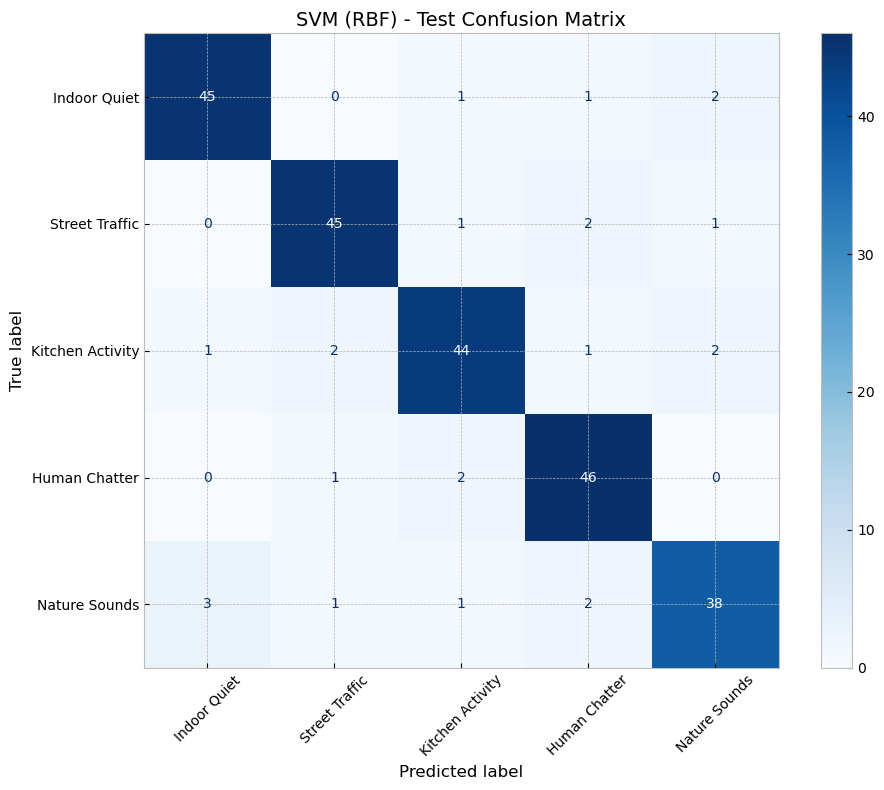

In [13]:
cm_test_svm = confusion_matrix(t_test, y_test_svm)

disp = ConfusionMatrixDisplay(cm_test_svm, display_labels=labels_names)
fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title('SVM (RBF) - Test Confusion Matrix', fontsize=14)
plt.tight_layout()
plt.show()

## 9. Model Comparison

In [14]:
results = {
    'Model': ['Logistic Regression', 'SVM (RBF)'],
    'Train Accuracy': [f'{train_acc_lr*100:.2f}%', f'{train_acc_svm*100:.2f}%'],
    'Test Accuracy': [f'{test_acc_lr*100:.2f}%', f'{test_acc_svm*100:.2f}%'],
    'Train F1 (weighted)': [f'{train_f1_lr:.4f}', f'{train_f1_svm:.4f}'],
    'Test F1 (weighted)': [f'{test_f1_lr:.4f}', f'{test_f1_svm:.4f}']
}

import pandas as pd
df_results = pd.DataFrame(results)
print('\n' + '='*80)
print('MODEL COMPARISON SUMMARY')
print('='*80)
print(df_results.to_string(index=False))
print('='*80)

target_f1 = 0.85
print(f"\nTarget F1-score: {target_f1:.2f}")
if test_f1_lr >= target_f1 or test_f1_svm >= target_f1:
    print(" TARGET ACHIEVED! One or more models meet the F1 ≥ 0.85 requirement.")
    if test_f1_svm > test_f1_lr:
        print(f" Best model: SVM with Test F1 = {test_f1_svm:.4f}")
    else:
        print(f" Best model: Logistic Regression with Test F1 = {test_f1_lr:.4f}")
else:
    print(" Target not met. Consider:")
    print("   1. Additional feature engineering (delta-MFCCs, chroma features)")
    print("   2. Data augmentation (time stretching, pitch shifting, noise)")
    print("   3. Deep learning approach (1D CNN) - see next notebook")


MODEL COMPARISON SUMMARY
              Model Train Accuracy Test Accuracy Train F1 (weighted) Test F1 (weighted)
Logistic Regression         86.16%        80.99%              0.8577             0.8078
          SVM (RBF)         97.73%        90.08%              0.9772             0.9006

Target F1-score: 0.85
 TARGET ACHIEVED! One or more models meet the F1 ≥ 0.85 requirement.
 Best model: SVM with Test F1 = 0.9006


## 10. Save Best Model

In [15]:
import pickle

if test_f1_svm > test_f1_lr:
    best_model = best_svm_model
    best_model_name = 'SVM'
    best_f1 = test_f1_svm
else:
    best_model = best_lr_model
    best_model_name = 'Logistic Regression'
    best_f1 = test_f1_lr

with open('best_classical_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

print(f"Best model saved: {best_model_name}")
print(f"Test F1-score: {best_f1:.4f}")
print("\nModel saved to: best_classical_model.pkl")

Best model saved: SVM
Test F1-score: 0.9006

Model saved to: best_classical_model.pkl


---

## 12. Advanced Feature Engineering (Iteration 2)

**Goal**: Extract additional audio features to improve performance on Nature Sounds and Kitchen Activity

**New Features**:
- **Delta-MFCCs** (13 features): First-order derivatives capturing temporal dynamics
- **Chroma** (12 features): Pitch class distribution (helps with harmonic content)
- **Spectral Contrast** (7 features): Distinguishes sharp vs smooth sounds
- **Tonnetz** (6 features): Tonal centroid features (harmonic relationships)

**Total new features**: +38 → **~100 features total**

In [16]:
def extract_advanced_audio_features(audio, sr=48000):
    features = []
    
    rms = librosa.feature.rms(y=audio)[0]
    features.append(np.mean(rms))
    features.append(np.std(rms))
    
    zcr = librosa.feature.zero_crossing_rate(audio)[0]
    features.append(np.mean(zcr))
    features.append(np.std(zcr))
    
    centroid = librosa.feature.spectral_centroid(y=audio, sr=sr)[0]
    features.append(np.mean(centroid))
    features.append(np.std(centroid))
    
    rolloff = librosa.feature.spectral_rolloff(y=audio, sr=sr)[0]
    features.append(np.mean(rolloff))
    features.append(np.std(rolloff))
    
    bandwidth = librosa.feature.spectral_bandwidth(y=audio, sr=sr)[0]
    features.append(np.mean(bandwidth))
    features.append(np.std(bandwidth))
    
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
    for coef in mfccs:
        features.append(np.mean(coef))
        features.append(np.std(coef))
        features.append(np.max(coef))
        features.append(np.min(coef))
    
    delta_mfccs = librosa.feature.delta(mfccs)
    for coef in delta_mfccs:
        features.append(np.mean(coef))
    
    chroma = librosa.feature.chroma_stft(y=audio, sr=sr)
    for coef in chroma:
        features.append(np.mean(coef))
    
    contrast = librosa.feature.spectral_contrast(y=audio, sr=sr)
    for coef in contrast:
        features.append(np.mean(coef))
    
    tonnetz = librosa.feature.tonnetz(y=librosa.effects.harmonic(audio), sr=sr)
    for coef in tonnetz:
        features.append(np.mean(coef))
    
    return np.array(features)

print("Testing advanced feature extraction...")
test_audio_adv = data_training[:, 0]
test_features_adv = extract_advanced_audio_features(test_audio_adv, SAMPLE_RATE)
print(f"Advanced feature vector shape: {test_features_adv.shape}")
print(f"Number of advanced features: {len(test_features_adv)}")

Testing advanced feature extraction...
Advanced feature vector shape: (100,)
Number of advanced features: 100


In [17]:
X_advanced = []

print(f"Extracting advanced features from {N_SAMPLES} audio samples...")
for i in range(N_SAMPLES):
    if i % 100 == 0:
        print(f"  Processing sample {i}/{N_SAMPLES}...")
    
    audio = data_training[:, i]
    features = extract_advanced_audio_features(audio, SAMPLE_RATE)
    X_advanced.append(features)

X_advanced = np.array(X_advanced)

print(f"\nAdvanced feature extraction complete!")
print(f"Advanced feature matrix shape: {X_advanced.shape}")
print(f"Improvement: {X_advanced.shape[1] - X.shape[1]} additional features")

Extracting advanced features from 1210 audio samples...
  Processing sample 0/1210...
  Processing sample 100/1210...
  Processing sample 200/1210...
  Processing sample 300/1210...
  Processing sample 400/1210...


c:\Users\devin\anaconda3\Lib\site-packages\librosa\core\pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


  Processing sample 500/1210...
  Processing sample 600/1210...
  Processing sample 700/1210...
  Processing sample 800/1210...
  Processing sample 900/1210...
  Processing sample 1000/1210...
  Processing sample 1100/1210...
  Processing sample 1200/1210...

Advanced feature extraction complete!
Advanced feature matrix shape: (1210, 100)
Improvement: 38 additional features


In [18]:
X_train_adv, X_test_adv, t_train_adv, t_test_adv = train_test_split(
    X_advanced, t,
    test_size=0.2,
    stratify=t,
    random_state=42
)

print(f"Advanced training set: {X_train_adv.shape}")
print(f"Advanced test set: {X_test_adv.shape}")

Advanced training set: (968, 100)
Advanced test set: (242, 100)


## 13. Retrain SVM with Advanced Features

In [19]:
print("Training SVM with advanced features...")
grid_svm_adv = GridSearchCV(
    estimator=svm_pipeline,
    param_grid=param_grid_svm,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=2
)

grid_svm_adv.fit(X_train_adv, t_train_adv)

print(f"\nBest Parameters (Advanced): {grid_svm_adv.best_params_}")
print(f"Best CV F1-score (Advanced): {grid_svm_adv.best_score_:.4f}")

Training SVM with advanced features...
Fitting 5 folds for each of 16 candidates, totalling 80 fits

Best Parameters (Advanced): {'classifier__C': 10, 'classifier__gamma': 0.005}
Best CV F1-score (Advanced): 0.9043


In [21]:
best_svm_adv_model = grid_svm_adv.best_estimator_

y_train_svm_adv = best_svm_adv_model.predict(X_train_adv)
y_test_svm_adv = best_svm_adv_model.predict(X_test_adv)

train_f1_svm_adv = f1_score(t_train_adv, y_train_svm_adv, average='weighted')
test_f1_svm_adv = f1_score(t_test_adv, y_test_svm_adv, average='weighted')

print('='*60)
print('SVM WITH ADVANCED FEATURES')
print('='*60)
print(f'Weighted F1 in Training: {train_f1_svm_adv:.4f}')
print(f'Weighted F1 in Test: {test_f1_svm_adv:.4f}')
print('='*60)

print(f" Comparison:")
print(f"   Baseline SVM (62 features):  Test F1 = {test_f1_svm:.4f}")
print(f"   Advanced SVM (~100 features): Test F1 = {test_f1_svm_adv:.4f}")
print(f"   Improvement: {(test_f1_svm_adv - test_f1_svm):.4f} ({(test_f1_svm_adv - test_f1_svm)*100:.2f}%)")

SVM WITH ADVANCED FEATURES
Weighted F1 in Training: 0.9979
Weighted F1 in Test: 0.9213
 Comparison:
   Baseline SVM (62 features):  Test F1 = 0.9006
   Advanced SVM (~100 features): Test F1 = 0.9213
   Improvement: 0.0207 (2.07%)


In [22]:
print('\nClassification Report - Training Set (Advanced Features):')
print(classification_report(t_train_adv, y_train_svm_adv, target_names=labels_names, digits=4))

print('\nClassification Report - Test Set (Advanced Features):')
print(classification_report(t_test_adv, y_test_svm_adv, target_names=labels_names, digits=4))


Classification Report - Training Set (Advanced Features):
                  precision    recall  f1-score   support

    Indoor Quiet     0.9949    1.0000    0.9975       196
  Street Traffic     0.9949    1.0000    0.9975       196
Kitchen Activity     1.0000    1.0000    1.0000       200
   Human Chatter     1.0000    1.0000    1.0000       195
   Nature Sounds     1.0000    0.9890    0.9944       181

        accuracy                         0.9979       968
       macro avg     0.9980    0.9978    0.9979       968
    weighted avg     0.9979    0.9979    0.9979       968


Classification Report - Test Set (Advanced Features):
                  precision    recall  f1-score   support

    Indoor Quiet     0.9167    0.8980    0.9072        49
  Street Traffic     0.9565    0.8980    0.9263        49
Kitchen Activity     0.9184    0.9000    0.9091        50
   Human Chatter     0.9057    0.9796    0.9412        49
   Nature Sounds     0.9130    0.9333    0.9231        45

        acc

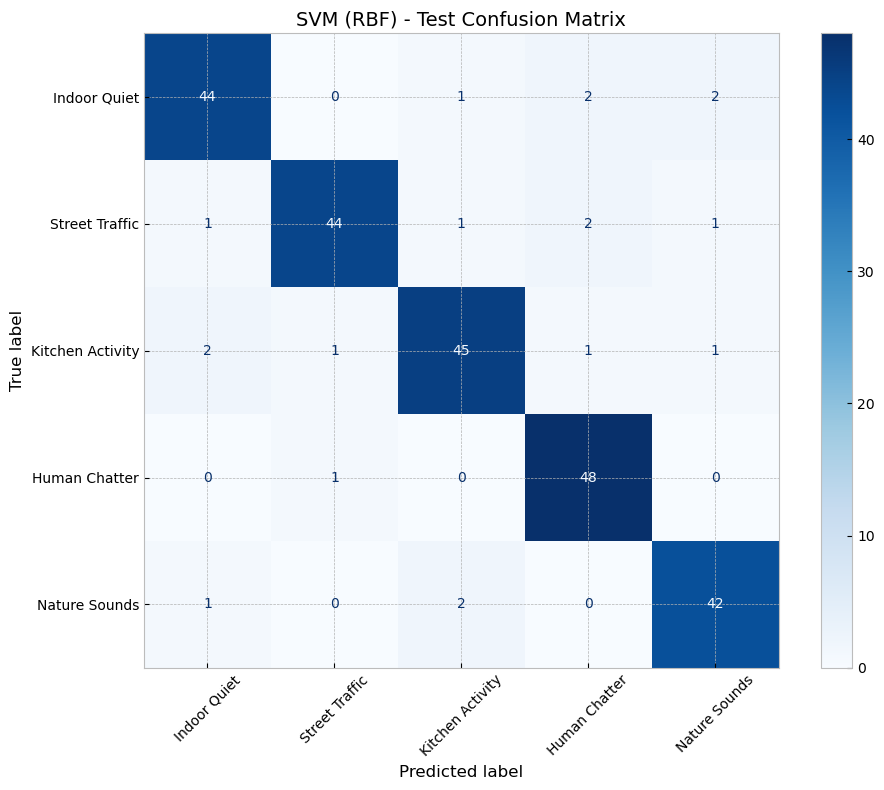

In [23]:
cm_test_svm_adv = confusion_matrix(t_test_adv, y_test_svm_adv)

disp = ConfusionMatrixDisplay(cm_test_svm_adv, display_labels=labels_names)
fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title('SVM (RBF) - Test Confusion Matrix', fontsize=14)
plt.tight_layout()
plt.show()